In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [33]:

import re

def parse_prediction(predicted_text_list,unit_list):

    pred_list=[]

    for i in range(len(predicted_text_list)):
        text=predicted_text_list[i]
        unit=unit_list[i]


        #正規表現で､「数値」 + unitを抽出｡数値は小数点やマイナスも含む｡unitの前にスペースがある場合もない場合もある
        #unit_pattern = re.escape(unit).replace(r'\[', r'\[?').replace(r'\]', r'\]?')
        #pattern = rf"-?\d+(\.\d+)?\s*{unit_pattern}"
        # 正規表現によるマッチング
        #match = re.search(pattern, text)

        # 正規表現パターンを定義: "is" の後に数値部分 (-?(\d+(\.\d+)?))
        pattern = r"is\s*(-?\d+(\.\d+)?)"

        # 正規表現によるマッチング
        match = re.search(pattern, text)
        if match:
            predict=(match.group())
            #predict=predict.replace(unit,"").strip()
            #predict=predict.replace(unit[1:-1],"").strip()
            predict=predict.replace("is ","").strip()
            pred_list.append(float(predict))
        else:
            pred_list.append(None)

    return pred_list

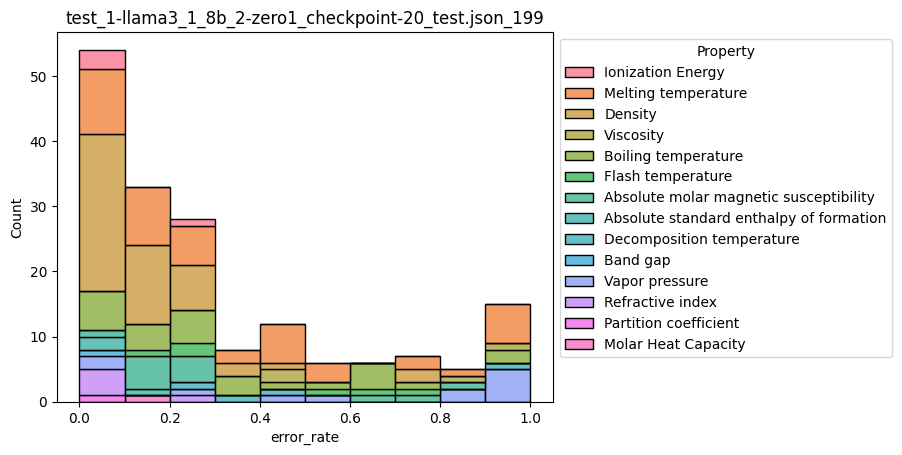

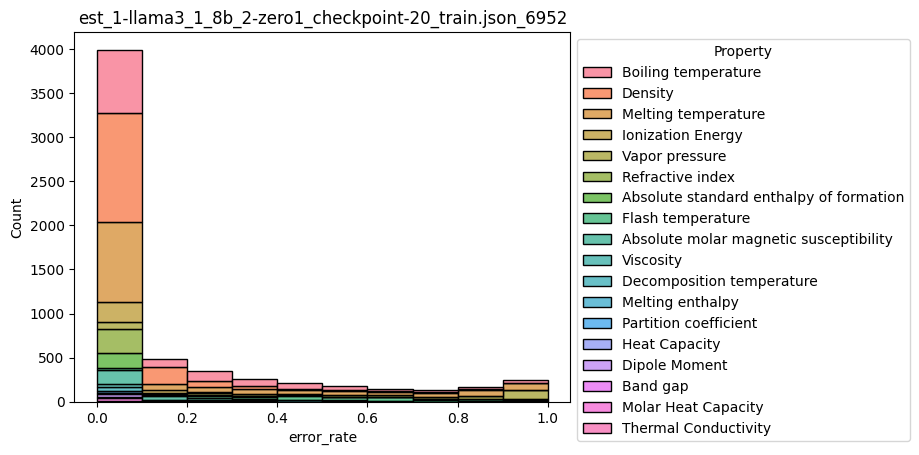

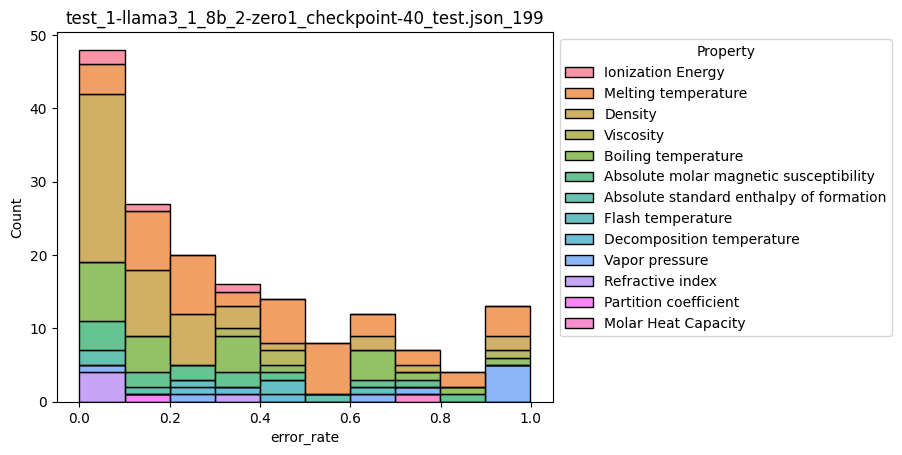

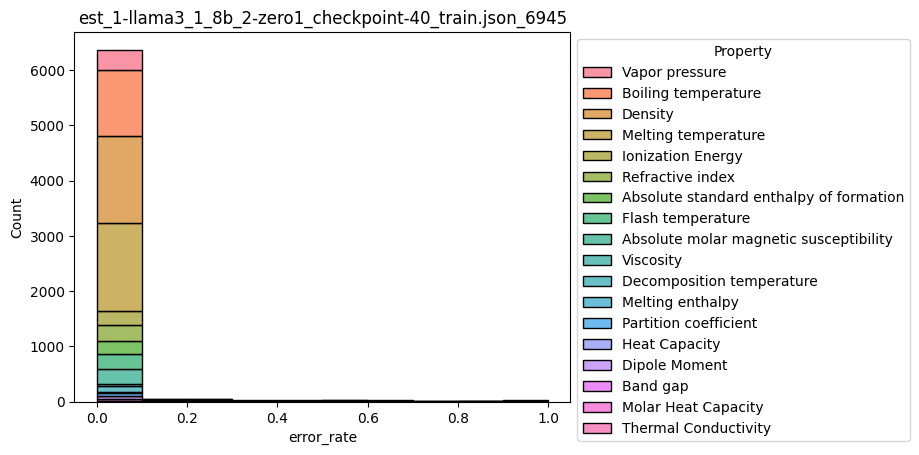

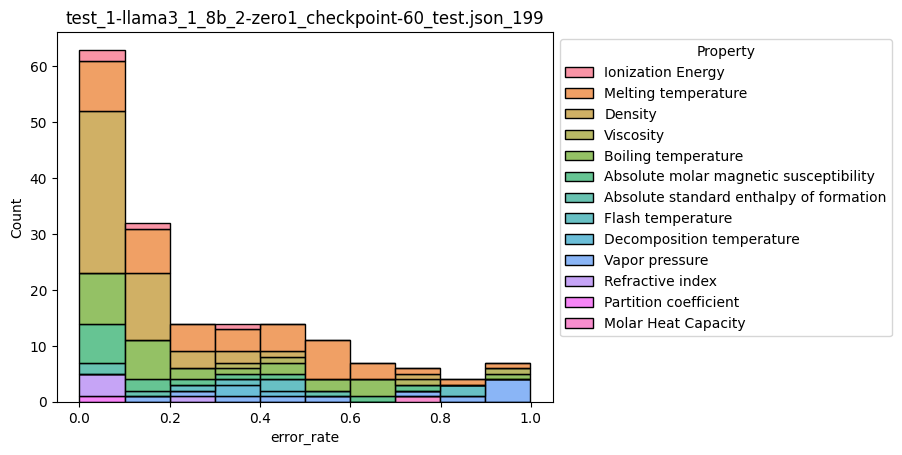

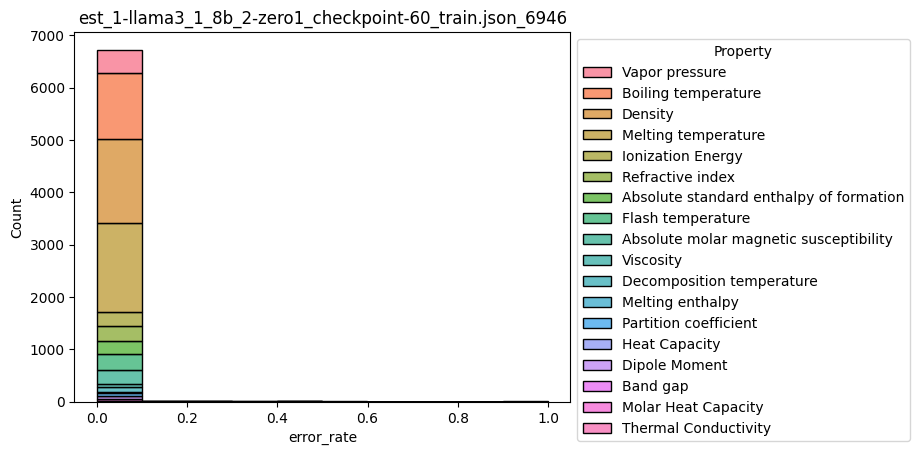

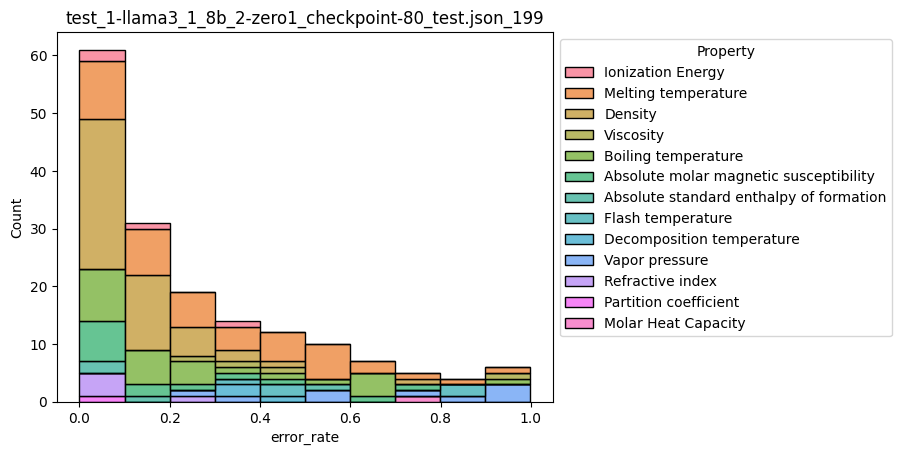

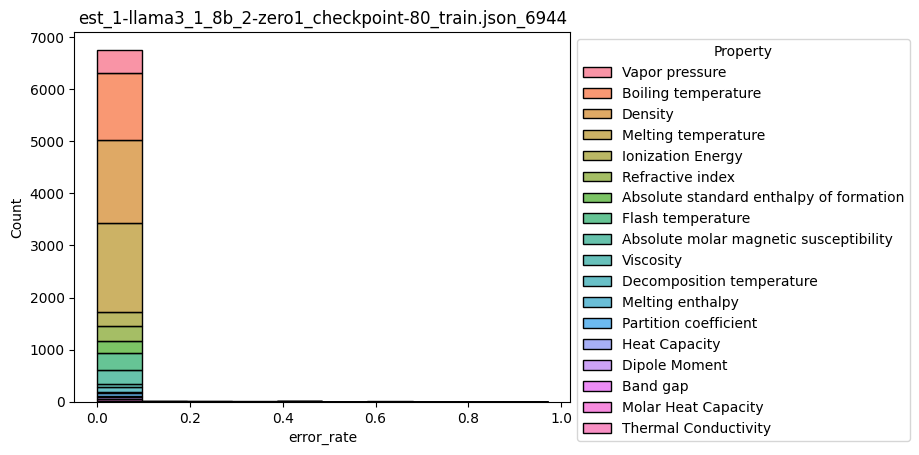

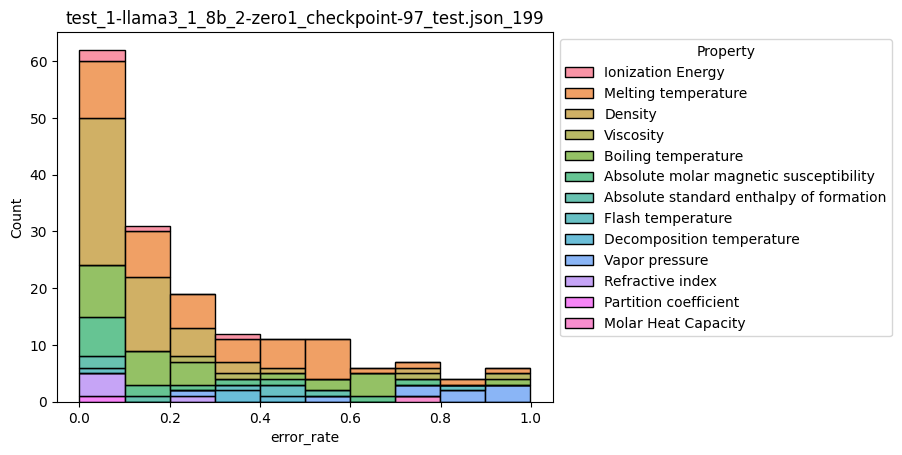

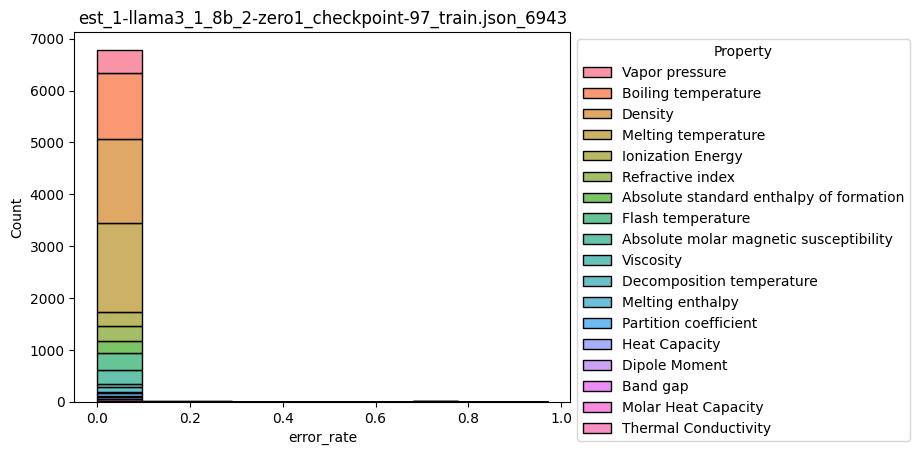

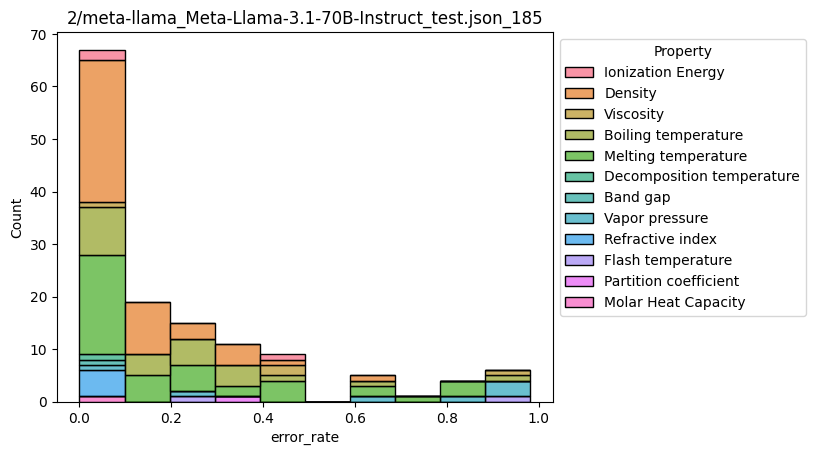

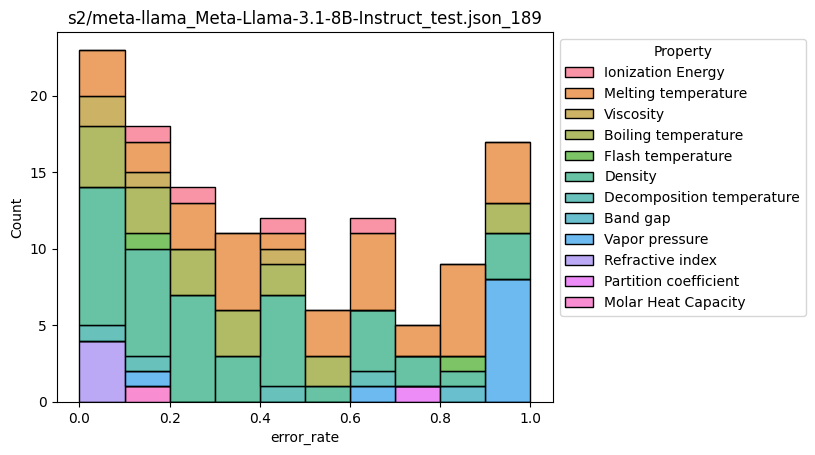

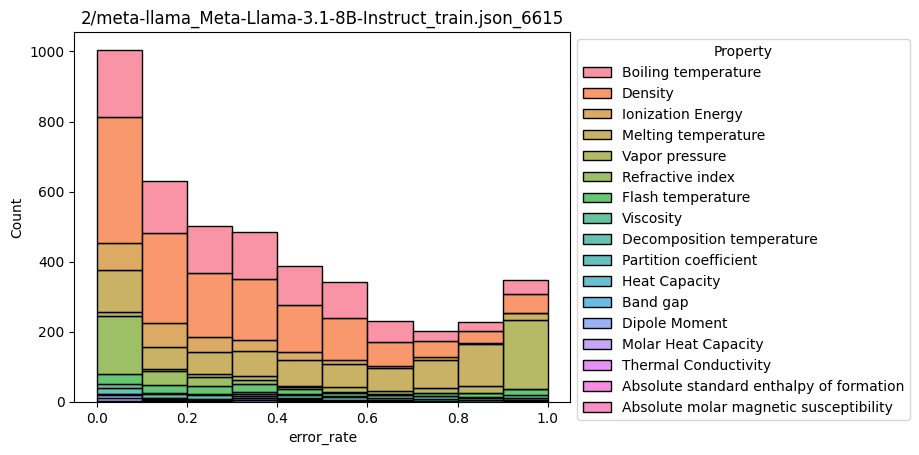

In [34]:
import glob
json_list=[]
json_list+=glob.glob("eval_results2/*.json")

#json_list+=glob.glob("/data/hatakeyama/self-loop/0920evaluate_prediction_accuracy/eval_results/*.json")

mode="test"

error_rate_dict={}

json_list.sort()

for target_json in json_list:

    #if target_json.find(mode)==-1:
    #    continue

    df=pd.read_json(target_json)
    #predicted_valueをfloatに変更｡変換できないものはNaNにする
    df["predicted_value_float"] = pd.to_numeric(df["predicted_value"], errors='coerce')

    if target_json.find("meta")==-1:
        predicted_text_list=df["predicted_text"].tolist()
        unit_list=df["unit"].tolist()
        predicted_value_list=parse_prediction(predicted_text_list,unit_list)
        df["predicted_value_float"]=predicted_value_list


    #actual_value, predicted_valueの誤差率を計算(絶対値を取る
    df["error_rate"]=(df["Value"]-df["predicted_value_float"])/df["Value"]
    df["error_rate"]=df["error_rate"].abs()

    #誤差率が0以上のものを抽出
    sel_df=df[df["error_rate"]>=0]
    sel_df["predicted_text"].tolist()

    #plt.figure()
    #plt.title(target_json)
    #sns.boxplot(x="error_rate",y="Property",data=sel_df)
    #plt.xlim(-1,2)
    #xはlog
    #plt.xscale("log")
    #x=0.1に縦線を引く
    #plt.axvline(x=0.1, color='r', linestyle='--')

    plt.figure()
    plt.title(target_json[-50:]+"_"+str(sel_df.shape[0]))
    #sns.histplot(data=sel_df,x="error_rate",bins=100,hue="Property")
    ax=sns.histplot(data=sel_df[sel_df["error_rate"]<1],x="error_rate",
                 bins=10,hue="Property",
                multiple="stack"
                 )
    #plt.xlim(0,1)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    error_rate_dict[target_json]=sel_df["error_rate"].median()

In [38]:
error_rate_df=pd.DataFrame(error_rate_dict.items(),columns=["json","median_error_rate"])
error_rate_df["json"].to_list()

['eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint-20_test.json',
 'eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint-20_train.json',
 'eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint-40_test.json',
 'eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint-40_train.json',
 'eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint-60_test.json',
 'eval_results2/_data_hatakeyama_self-loop_0924split_train_test_sftlab_experiments_test_1_output_sftlab-experiments_test_1-llama3_1_8b_2-zero1_checkpoint

<Axes: xlabel='step', ylabel='median_error_rate'>

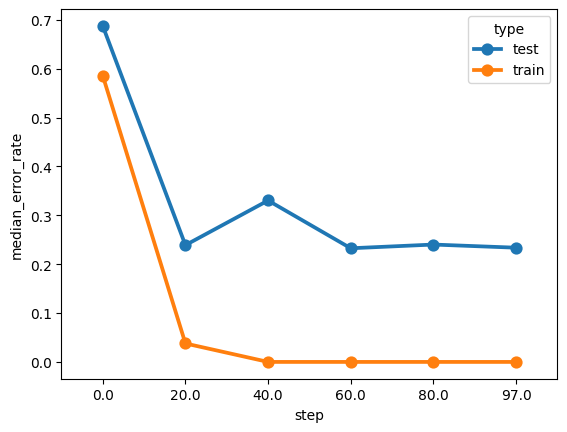

In [44]:
error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="step",y="median_error_rate",hue="type")

In [54]:
#1 stepあたりの学習データ数
trained_records=200000
trained_facts=trained_records*2.5

tot_augment_records=1398000*2.5
print(tot_augment_records)

augment_ratio=tot_augment_records/7000 # 合成テキスト数/元の物性数 * 1テキストあたりの物性数
tot_steps=97
#augment_per_step=augment_ratio*tot_records/tot_steps
#augment_per_step*tot_steps
facts_per_step=trained_facts/tot_steps
seen_times_per_step=facts_per_step/augment_ratio
seen_times_per_step

3495000.0


10.324026960458976

<Axes: xlabel='Average seen times', ylabel='median_error_rate'>

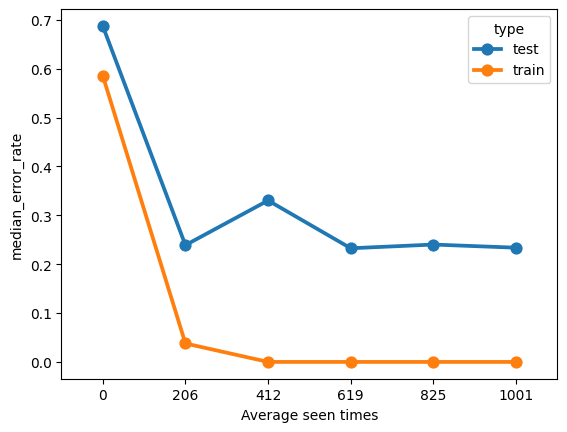

In [60]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["step"] = error_rate_df["step"].fillna(0)
#error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
error_rate_df["type"]=error_rate_df["json"].str.split("_").str[-1].str.split(".").str[0]
error_rate_df["Average seen times"]=(seen_times_per_step*error_rate_df["step"]).astype(int)
sns.pointplot(data=error_rate_df[error_rate_df["json"].str.find("70B")==-1],x="Average seen times",y="median_error_rate",hue="type")

In [58]:
error_rate_df

,json,median_error_rate,temp,step,type,Average seen times
0,eval_results2/_data_hatakeyama_self-loop_0924s...,0.238938,20_test,20.0,test,206.480539
1,eval_results2/_data_hatakeyama_self-loop_0924s...,0.037736,20_train,20.0,train,206.480539
2,eval_results2/_data_hatakeyama_self-loop_0924s...,0.330328,40_test,40.0,test,412.961078
3,eval_results2/_data_hatakeyama_self-loop_0924s...,0.000000,40_train,40.0,train,412.961078
4,eval_results2/_data_hatakeyama_self-loop_0924s...,0.232558,60_test,60.0,test,619.441618
5,eval_results2/_data_hatakeyama_self-loop_0924s...,0.000000,60_train,60.0,train,619.441618
6,eval_results2/_data_hatakeyama_self-loop_0924s...,0.240157,80_test,80.0,test,825.922157
7,eval_results2/_data_hatakeyama_self-loop_0924s...,0.000000,80_train,80.0,train,825.922157
8,eval_results2/_data_hatakeyama_self-loop_0924s...,0.233716,97_test,97.0,test,1001.430615
9,eval_results2/_data_hatakeyama_self-loop_0924s...,0.000000,97_train,97.0,train,1001.430615


<Axes: xlabel='step', ylabel='median_error_rate'>

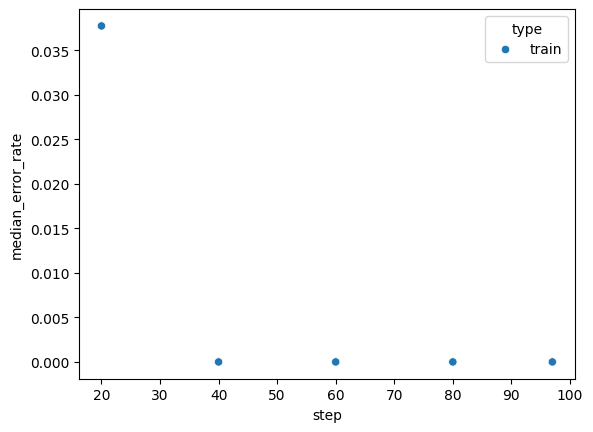

In [18]:

error_rate_df["temp"]=error_rate_df["json"].str.split("checkpoint-").str[-1].str.split(".").str[0]
error_rate_df["step"]=error_rate_df["temp"].str.split("_").str[0]
error_rate_df["step"] = pd.to_numeric(error_rate_df["step"], errors='coerce')
error_rate_df["type"]=error_rate_df["temp"].str.split("_").str[1]
sns.scatterplot(data=error_rate_df[error_rate_df["type"]=="train"],x="step",y="median_error_rate",hue="type")